In [1]:
import pandas as pd

In [2]:
file = pd.read_csv('abcnews-date-text.csv')
file.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [3]:
import missingno as msno

<AxesSubplot:>

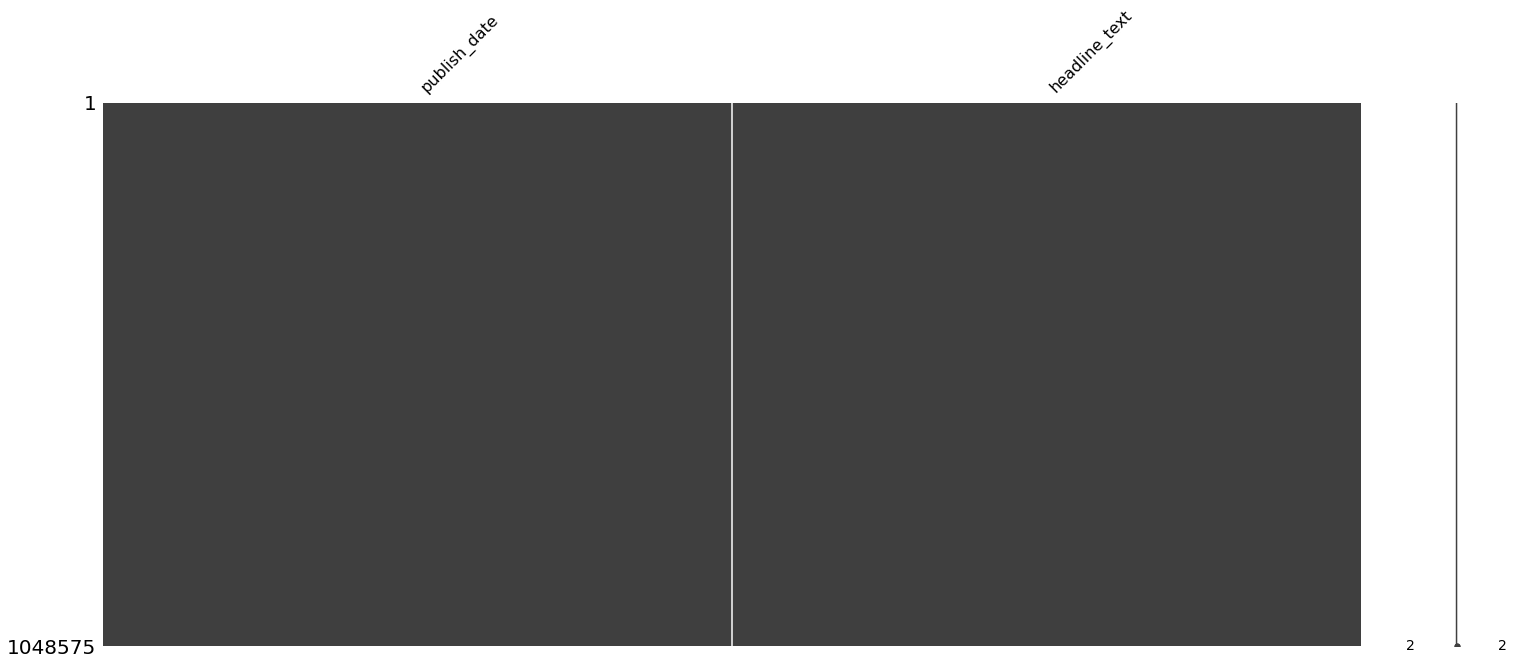

In [4]:
msno.matrix(file)

In [5]:
file.isna().sum()

publish_date     0
headline_text    0
dtype: int64

In [6]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1048575 non-null  int64 
 1   headline_text  1048575 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


In [7]:
comment_words = " ".join(file['headline_text'].values)

In [8]:
comment_words[:100]

'aba decides against community broadcasting licence act fire witnesses must be aware of defamation a '

In [9]:
from wordcloud import WordCloud, STOPWORDS

In [10]:
stopwords = set(STOPWORDS)

In [11]:
wordcloud = WordCloud(width = 3500, height = 2500, random_state = None,
         stopwords = STOPWORDS).generate(comment_words)

In [12]:
import matplotlib.pyplot as plt 

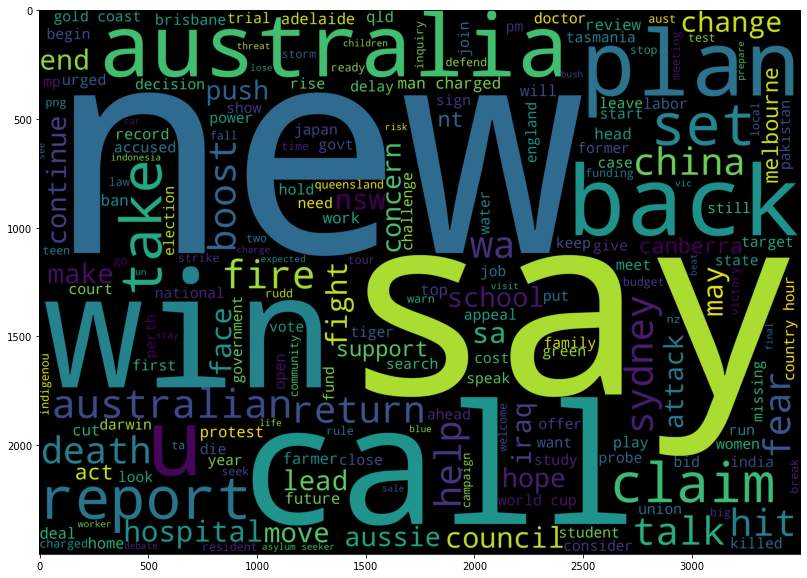

In [13]:
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.show()

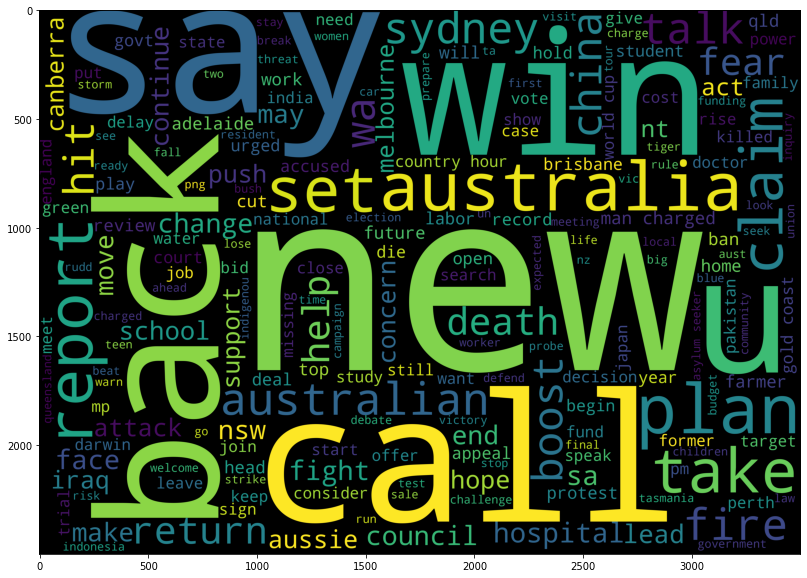

In [14]:
wordcloud = WordCloud(width = 3500, height = 2500, random_state = 10,
         stopwords = STOPWORDS).generate(comment_words)

plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.show()

In [18]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook 

output_notebook()

%matplotlib inline

Loading BokehJS ...

In [19]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [20]:
reindexed_data = file['headline_text']
reindexed_data.index = file['publish_date']

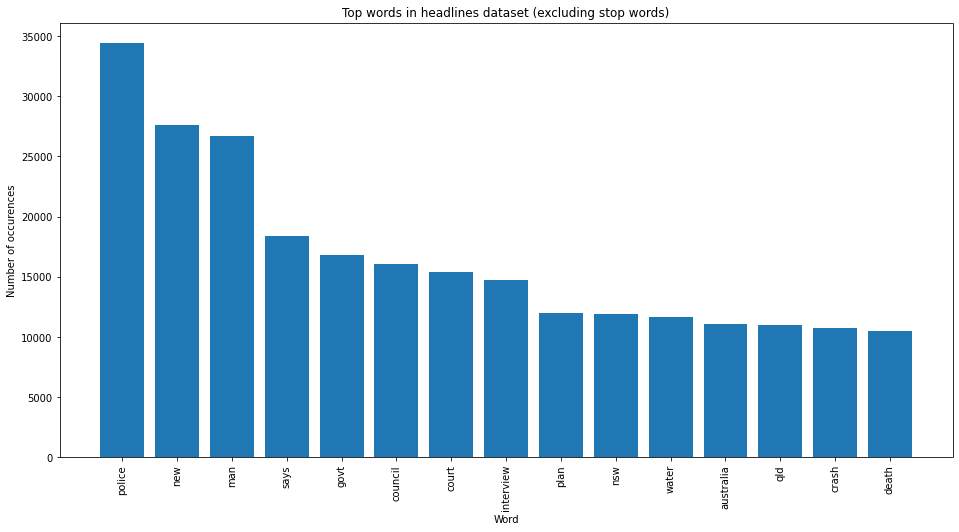

In [21]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [22]:
tagged_headlines = [TextBlob(file.loc[i,'headline_text']).pos_tags for i in range(reindexed_data.shape[0])]

In [23]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  6632306
Mean number of words per headline:  6.325065922799991


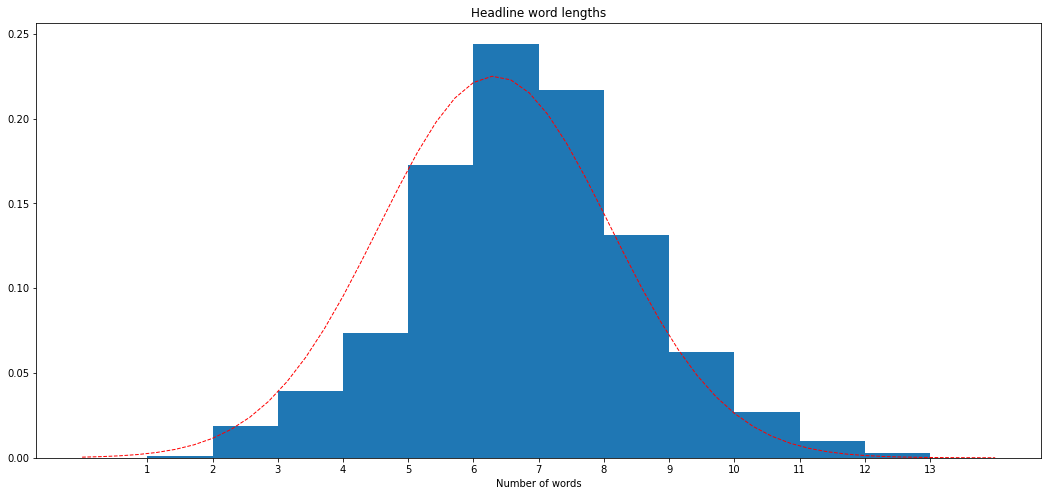

In [24]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

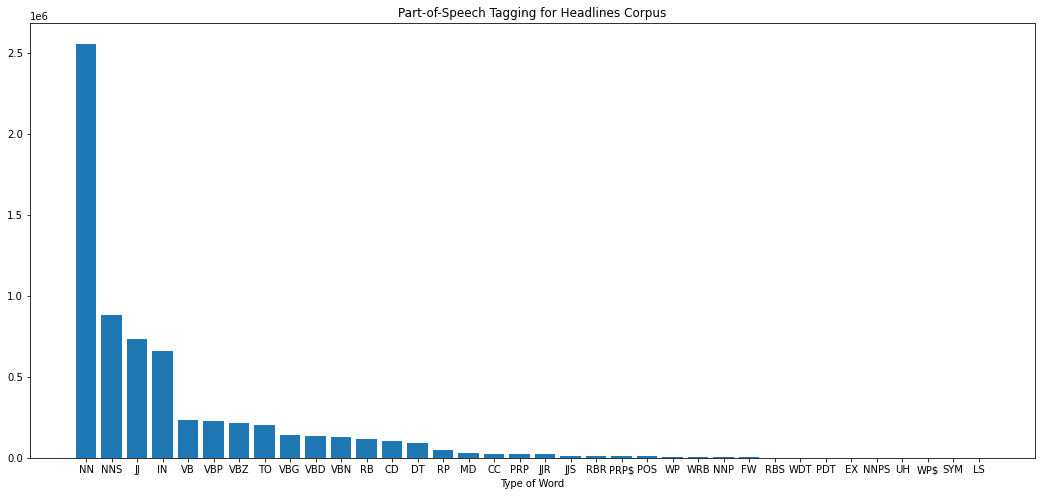

In [25]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

In [26]:
file['publish_date'] = file['publish_date'].astype(str)
time_data = pd.to_datetime(file['publish_date'], format = '%Y%m%d')

year = time_data.dt.strftime('%Y')
yearly_counts = year.count()

month = time_data.dt.strftime('%Y%m')
monthly_counts = month.count()

day = time_data.dt.strftime('%Y%m%d')
daily_counts = day.count()

<AxesSubplot:>

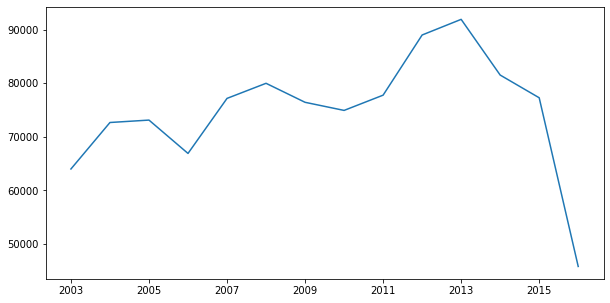

In [27]:
year.value_counts().sort_index().plot(kind='line', figsize = (10,5))

<AxesSubplot:>

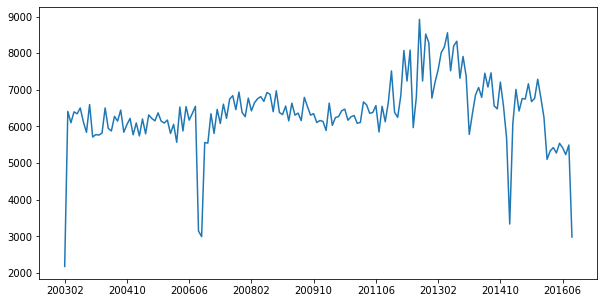

In [28]:
month.value_counts().sort_index().plot(kind='line', figsize = (10,5))

<AxesSubplot:>

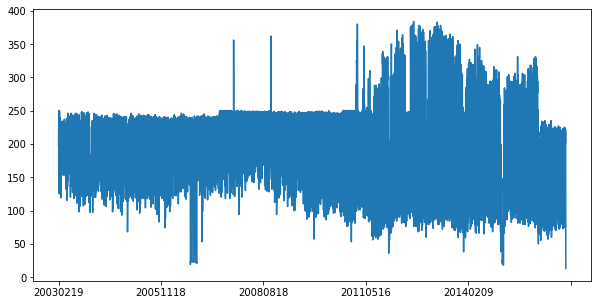

In [29]:
day.value_counts().sort_index().plot(kind='line', figsize = (10,5))

In [30]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: st albans house damaged in overnight blaze
Headline after vectorization: 
  (0, 10137)	1
  (0, 523)	1
  (0, 5249)	1
  (0, 2893)	1
  (0, 7639)	1
  (0, 1371)	1


In [31]:
n_topics = 8

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [32]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [33]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [34]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [35]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  police death probe missing attack sydney investigate search man hunt
Topic 2:  new laws set year australia england state sales warning team
Topic 3:  man charged jailed guilty murder child court dies car arrested
Topic 4:  says china budget mp pm union industry funding change opposition
Topic 5:  council plan water fears calls boost urged claims plans mayor
Topic 6:  govt wa indigenous nt help urged abuse water rail fed
Topic 7:  qld crash rural report australia hit car world national day
Topic 8:  interview court nsw accused australian murder government trial charges drug


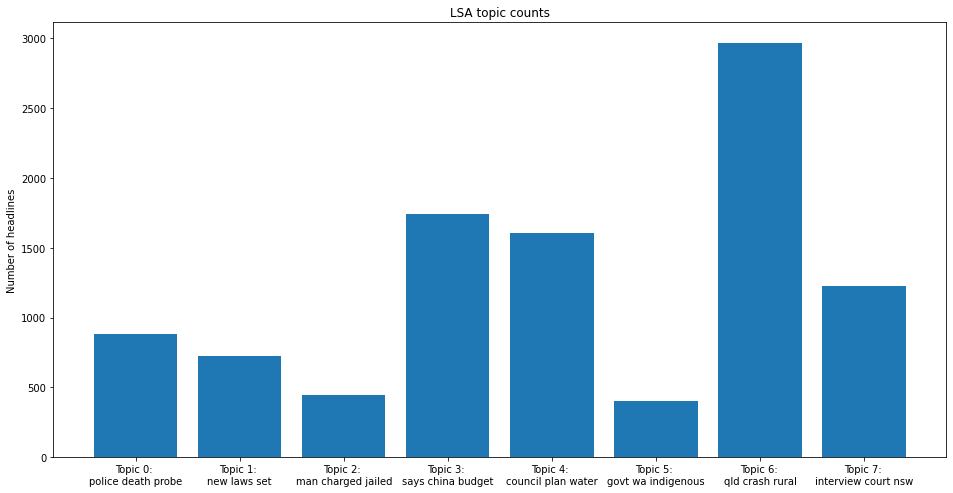

In [36]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [37]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.019s...
[t-SNE] Computed neighbors for 10000 samples in 2.603s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.337593
[t-SNE] KL divergence after 2000 iterations: 1.224442


In [38]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [39]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [40]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

<b>Latent Dirichilet Allocation</b>

In [42]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [43]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [44]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  police australia plan country australian hour sex election sa abc
Topic 2:  says court qld nsw accused report drug murder police win
Topic 3:  water says woman new minister boost dies child urged china
Topic 4:  council talks calls plans road injured nt change rail hill
Topic 5:  new govt police wa market missing school fears sydney centre
Topic 6:  new home death council charges hospital man work government police
Topic 7:  health world cup car lead pay strike workers funds indigenous
Topic 8:  man interview crash charged rural killed police national day coast


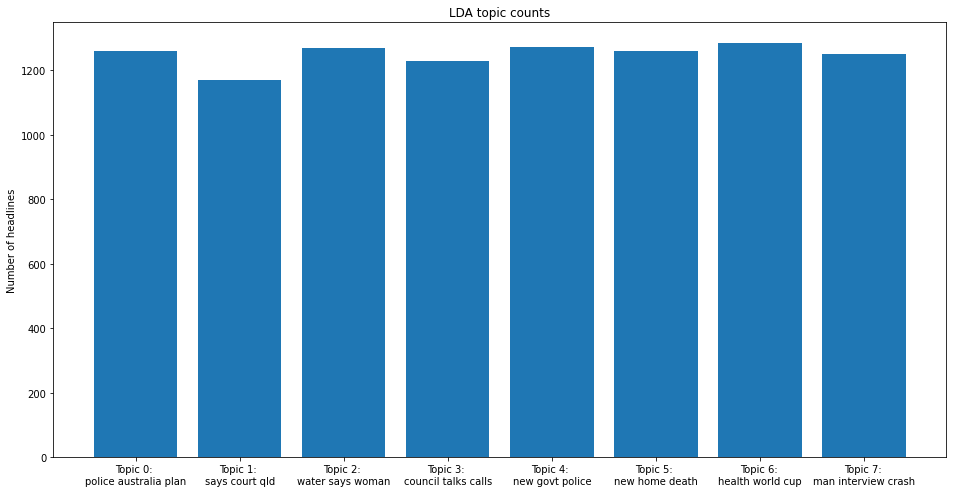

In [45]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [46]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 1.508s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.909637
[t-SNE] KL divergence after 2000 iterations: 1.222976


In [47]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

<h2>Scaling Up</h2>
<b>Now that we have found an effective clustering algorithm, we can scale it up. We still have to work with a subsample, as it is infeasible to train an LDA model one million observations, but we can significantly increase our scope to  100,000  headlines.</b>

In [49]:
big_sample_size = 100000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

In [53]:
reindexed_data = file['headline_text']
reindexed_data.index = file['publish_date']

In [ ]:
yearly_data = []
for i in range(2003,2017+1):
    yearly_data.append(reindexed_data[i])

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2017+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

print(yearly_topic_counts)

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()

In [ ]:
https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda